In [43]:
import pickle

import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from stellargraph.data import EdgeSplitter
from tensorflow.keras import Model, optimizers, losses, metrics
from het_data import HetGraph

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load graph
hg = pickle.load(open('res/graphs/50_img_non_pyg.hg', 'rb'))
data = hg.get_stellar_graph()

In [3]:
print(data.info())

StellarGraph: Undirected multigraph
 Nodes: 213, Edges: 14702

 Node types:
  word: [163]
    Features: float32 vector, length 300
    Edge types: word-image2word->image, word-word2word->word
  image: [50]
    Features: float32 vector, length 512
    Edge types: image-image2image->image, image-image2word->word

 Edge types:
    word-word2word->word: [13203]
        Weights: range=[-0.289893, 0.813978], mean=0.128848, std=0.131232
        Features: none
    image-image2image->image: [1225]
        Weights: range=[0.185038, 0.78686], mean=0.554056, std=0.106663
        Features: none
    image-image2word->word: [274]
        Weights: all 1 (default)
        Features: none


In [88]:
batch_size = 20
epochs = 10
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

In [9]:
type(data.edges())

list

### Getting the list of all positive image to word edges in a dataframe

This is not needed anymore

In [37]:
edges = data.edges(include_edge_type=True, include_edge_weight=False)
edges = pd.DataFrame(edges, columns=['image', 'word', 'type'])
edges = edges[edges.type == 'image2word'].reset_index()[['image', 'word']]
edges

,image,word
0,VizWiz_train_00000001.jpg,green
1,VizWiz_train_00000001.jpg,white
2,VizWiz_train_00000001.jpg,plastic
3,VizWiz_train_00000001.jpg,condiment
4,VizWiz_train_00000001.jpg,bottle
...,...,...
269,VizWiz_train_00000051.jpg,white
270,VizWiz_train_00000051.jpg,samsung
271,VizWiz_train_00000051.jpg,cell
272,VizWiz_train_00000051.jpg,phone


### Trying to split the data using an example from a GCN binary link prediction

https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html

This seems to be the correct splitting

In [83]:
edge_splitter_test = EdgeSplitter(data)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, edges_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", edge_label='image2word'
)

print(graph_test.info())

Network has 274 edges of type image2word
Network has 274 edges of type image2word
** Sampled 27 positive and 27 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 213, Edges: 14675

 Node types:
  word: [163]
    Features: float32 vector, length 300
    Edge types: word-image2word->image, word-word2word->word
  image: [50]
    Features: float32 vector, length 512
    Edge types: image-image2image->image, image-image2word->word

 Edge types:
    word-word2word->word: [13203]
        Weights: range=[-0.289893, 0.813978], mean=0.128848, std=0.131232
        Features: none
    image-image2image->image: [1225]
        Weights: range=[0.185038, 0.78686], mean=0.554056, std=0.106663
        Features: none
    image-image2word->word: [247]
        Weights: all 1 (default)
        Features: none


In [86]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, data)
graph, edges, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global", edge_label='image2word'
)


# probably don't need this step as we're already using this model
(
    edges_train,
    edges_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(edges, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

Network has 247 edges of type image2word
Network has 247 edges of type image2word
** Sampled 24 positive and 24 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 213, Edges: 14651

 Node types:
  word: [163]
    Features: float32 vector, length 300
    Edge types: word-image2word->image, word-word2word->word
  image: [50]
    Features: float32 vector, length 512
    Edge types: image-image2image->image, image-image2word->word

 Edge types:
    word-word2word->word: [13203]
        Weights: range=[-0.289893, 0.813978], mean=0.128848, std=0.131232
        Features: none
    image-image2image->image: [1225]
        Weights: range=[0.185038, 0.78686], mean=0.554056, std=0.106663
        Features: none
    image-image2word->word: [223]
        Weights: all 1 (default)
        Features: none


In [85]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")


,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,36,Train Graph,Test Graph,Train the Link Classifier
Model Selection,12,Train Graph,Test Graph,Select the best Link Classifier model
Test set,54,Test Graph,Full Graph,Evaluate the best Link Classifier


### Trying to split the data to perform binary link prediction

used split from: https://github.com/stellargraph/stellargraph/discussions/1795

This is most likely correct as well but a lot more work for the same result

In [47]:
train_test_ratio = 0.05

# create reduce graph and edges for test data
edges_rg_test, edges_test = train_test_split(
    edges, train_size= 1 - train_test_ratio , test_size=train_test_ratio
)

# create reduce graph and edges for train data
edges_rg_train, edges_train = train_test_split(
    edges_rg_test, train_size= 1 - train_test_ratio , test_size=train_test_ratio
)

In [ ]:
# convert test and train reduce graphs into stellargraph format
# graph_test = StellarGraph({"eater": eater_nodes, "merchant": merchant_nodes}, edges_rg_test)
# graph_train = StellarGraph({"eater": eater_nodes, "merchant": merchant_nodes}, edges_rg_train)

# convert ids into series
image_ids = edges.image.to_numpy()
word_ids = edges.word.to_numpy()

# generate all possible edges
all_possible_edges = pd.DataFrame(
    {
        "image": np.random.choice(image_ids, size=50),
        "word": np.random.choice(word_ids, size=163),
        "weight": 0
    }
)

# generate negative edges 
# TODO: need to add a column of ones to the edges dataframe
all_possible_edges = pd.concat([all_possible_edges,edges])
all_possible_edges = all_possible_edges.groupby(['image', 'word'])['weight'].agg('sum').reset_index()
neg_edge_df = all_possible_edges.loc[all_possible_edges['weight'] == 0]


# sample the negative edge cases for test (same number as positive edge cases)
neg_test_ratio = len(edges_test)/len(neg_edge_df)

edges_neg, edges_neg_test = model_selection.train_test_split(
    neg_edge_df, train_size=(1.0 - neg_test_ratio), test_size= neg_test_ratio
)

# sample the negative edge cases for train (same number as positive edge cases)
neg_train_ratio = len(edges_train)/len(edges_neg)

edges_neg, edges_neg_train = model_selection.train_test_split(
    edges_neg, train_size=(1.0 - neg_train_ratio), test_size= neg_train_ratio
)

# combine pos and neg cases to train and test
edges_test = pd.concat([edges_test,edges_neg_test])
edges_train = pd.concat([edges_train,edges_neg_train])

# create edgelist and labels
examples_train = list(edges_train[["source", "target"]].itertuples(index=False))
examples_test = list(edges_test[["source", "target"]].itertuples(index=False))

labels_train = edges_train["weight"]
labels_test = edges_test["weight"]

## Creating the model

based on HinSAGE link prediction tutorial from: https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/hinsage-link-prediction.html

In [90]:
num_samples = [8, 4]

generator = HinSAGELinkGenerator(
    data, batch_size, num_samples, head_node_types=["word", "image"]
)
train_gen = generator.flow(edges, labels, shuffle=True)
test_gen = generator.flow(edges_test, labels_test)

In [91]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('word', [2, 3]),
 ('image', [4, 5]),
 ('image', [6, 7]),
 ('word', [8, 9]),
 ('image', [10, 11]),
 ('word', [12, 13]),
 ('image', []),
 ('word', []),
 ('image', []),
 ('word', []),
 ('image', []),
 ('word', []),
 ('image', []),
 ('word', [])]

In [92]:
generator.schema.schema

{'word': [EdgeType(n1='word', rel='image2word', n2='image'),
  EdgeType(n1='word', rel='word2word', n2='word')],
 'image': [EdgeType(n1='image', rel='image2image', n2='image'),
  EdgeType(n1='image', rel='image2word', n2='word')]}

In [93]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)

In [94]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.in_out_tensors()

In [96]:
# Final estimator layer
score_prediction = link_regression(edge_embedding_method="concat")(x_out)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


In [97]:
import tensorflow.keras.backend as K


def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

In [98]:
# Specify the number of workers to use for model training
num_workers = 4

In [99]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

3/3 [==============================] - 2s 21ms/step - loss: 1.2662 - root_mean_square_error: 1.0374 - mean_absolute_error: 1.0092
Untrained model's Test Evaluation:
	loss: 0.9785
	root_mean_square_error: 0.8463
	mean_absolute_error: 0.8361


In [100]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

Epoch 1/10
3/3 [==============================] - 4s 175ms/step - loss: 0.6674 - root_mean_square_error: 0.7348 - mean_absolute_error: 0.7001 - val_loss: 0.2538 - val_root_mean_square_error: 0.4984 - val_mean_absolute_error: 0.5002
Epoch 2/10
3/3 [==============================] - 0s 137ms/step - loss: 0.2530 - root_mean_square_error: 0.5029 - mean_absolute_error: 0.4927 - val_loss: 0.2625 - val_root_mean_square_error: 0.4958 - val_mean_absolute_error: 0.5006
Epoch 3/10
3/3 [==============================] - 0s 131ms/step - loss: 0.2446 - root_mean_square_error: 0.4883 - mean_absolute_error: 0.4891 - val_loss: 0.2540 - val_root_mean_square_error: 0.5060 - val_mean_absolute_error: 0.4997
Epoch 4/10
3/3 [==============================] - 0s 141ms/step - loss: 0.2388 - root_mean_square_error: 0.4888 - mean_absolute_error: 0.4832 - val_loss: 0.2551 - val_root_mean_square_error: 0.5075 - val_mean_absolute_error: 0.5008
Epoch 5/10
3/3 [==============================] - 0s 129ms/step - loss: 

In [101]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

3/3 [==============================] - 0s 23ms/step - loss: 0.2651 - root_mean_square_error: 0.5058 - mean_absolute_error: 0.5056
Test Evaluation:
	loss: 0.2651
	root_mean_square_error: 0.5058
	mean_absolute_error: 0.5056


In [102]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  0.5
	mean_absolute_error =  0.5

Model Test set metrics:
	root_mean_square_error =  0.5137414903352675
	mean_absolute_error =  0.5044964872024678


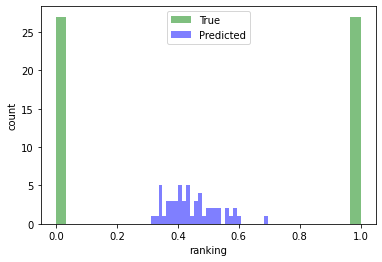

In [103]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()